In [7]:
import nltk
import sklearn_crfsuite
import eli5
import pprint
import ast
import scipy
from joblib import load, dump
from nltk.tag import pos_tag
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn_crfsuite import metrics, scorers
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# loading datasets
f = open("train_with_pos.txt")
train_sets = ast.literal_eval(f.read())
f = open("test_with_pos.txt")
test_sets = ast.literal_eval(f.read())

In [3]:
# defining features
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [4]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [5]:
X_train = [sent2features(s) for s in train_sets]
y_train = [sent2labels(s) for s in train_sets]

X_test = [sent2features(s) for s in test_sets]
y_test = [sent2labels(s) for s in test_sets]

pprint.pprint(X_train[0][1])

{'+1:postag': ':',
 '+1:postag[:2]': ':',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': ':',
 '-1:postag': 'NN',
 '-1:postag[:2]': 'NN',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:word.lower()': 'android',
 'bias': 1.0,
 'postag': 'NN',
 'postag[:2]': 'NN',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'path',
 'word[-3:]': 'ath'}


## Training CRF model with hand-picked parameters

In [4]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=20,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=20,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [5]:
eli5.show_weights(crf)

From \ To,O,B-API,I-API,B-Fram,I-Fram,B-PL,I-PL,B-Plat,I-Plat,B-Stan,I-Stan
O,2.275,1.222,0.0,0.548,0.0,0.25,0.0,0.171,0.0,0.299,0.0
B-API,0.609,0.0,1.673,0.0,0.0,-0.31,0.0,0.0,0.0,-0.207,0.0
I-API,0.0,0.0,0.123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-Fram,0.336,-0.344,0.0,0.0,2.008,-0.319,0.0,0.0,0.0,-0.158,0.0
I-Fram,-0.417,0.0,0.0,0.0,0.896,-0.095,0.0,-0.005,0.0,0.0,0.0
B-PL,0.458,0.0,0.0,-0.094,0.0,0.0,0.185,0.0,0.0,-0.118,0.0
I-PL,-0.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-Plat,-0.025,0.0,0.0,-0.021,0.0,0.0,0.0,0.0,0.5,0.001,0.0
I-Plat,-0.445,-0.013,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.0,0.0
B-Stan,-0.031,-0.157,0.0,0.0,0.0,-0.169,0.0,0.0,0.0,0.0,0.643


In [43]:
y_pred = crf.predict(X_test)
precision = metrics.flat_precision_score(y_test, y_pred, 
                      average='micro', labels=labels)
print(f'Best precision score: {precision}')

Best precision score: 0.750


In [8]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-API      0.585     0.133     0.217       983
       I-API      0.000     0.000     0.000        57
      B-Fram      0.658     0.339     0.447       590
      I-Fram      0.482     0.281     0.355       146
        B-PL      0.909     0.790     0.845       604
        I-PL      0.000     0.000     0.000        15
      B-Plat      0.870     0.516     0.648        91
      I-Plat      0.000     0.000     0.000        23
      B-Stan      0.718     0.175     0.282       291
      I-Stan      0.000     0.000     0.000        30

   micro avg      0.750     0.335     0.463      2830
   macro avg      0.422     0.223     0.279      2830
weighted avg      0.661     0.335     0.417      2830



## Searching for the best parameters

In [19]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 108.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13c6bc110>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13c6bca90>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=Fal

In [20]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.10696035819552788, 'c2': 0.004624834074348467}
best CV score: 0.9929071450436228
model size: 0.37M


Dark blue => 0.9802, dark red => 0.9929


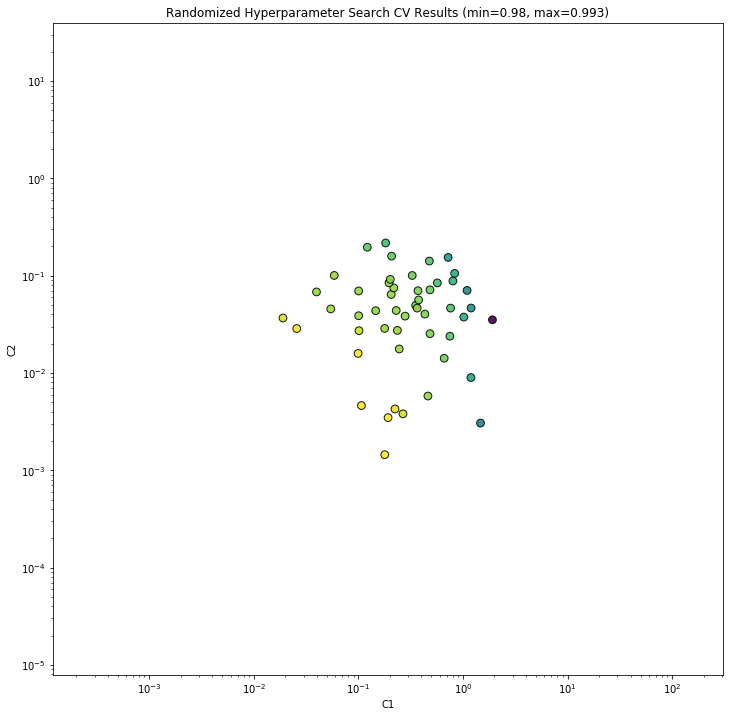

In [35]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Results of the best CRF model

In [22]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-API      0.984     0.980     0.982       983
       I-API      0.983     1.000     0.991        57
      B-Fram      0.998     1.000     0.999       590
      I-Fram      1.000     1.000     1.000       146
        B-PL      1.000     0.998     0.999       604
        I-PL      1.000     1.000     1.000        15
      B-Plat      1.000     1.000     1.000        91
      I-Plat      1.000     1.000     1.000        23
      B-Stan      1.000     1.000     1.000       291
      I-Stan      1.000     1.000     1.000        30

   micro avg      0.994     0.993     0.993      2830
   macro avg      0.996     0.998     0.997      2830
weighted avg      0.994     0.993     0.993      2830



In [41]:
eli5.show_weights(crf)

From \ To,O,B-API,I-API,B-Fram,I-Fram,B-PL,I-PL,B-Plat,I-Plat,B-Stan,I-Stan
O,2.641,0.526,-6.897,0.138,-8.453,-0.504,-5.7,0.0,-5.438,0.002,-5.863
B-API,0.224,-5.94,2.943,-2.651,-2.95,-0.069,0.0,0.0,0.0,-2.437,-0.169
I-API,-0.693,-4.352,2.876,0.0,-0.308,0.0,0.0,0.0,0.0,-0.85,0.0
B-Fram,-0.229,-1.308,-8.52,-2.685,3.66,-1.292,0.0,0.0,-0.63,-4.666,-3.708
I-Fram,-0.569,-1.834,-0.732,-1.778,5.178,0.0,0.0,0.012,0.0,-1.003,0.0
B-PL,0.141,-5.552,-9.082,-0.016,-8.916,-6.251,2.775,-0.279,-1.774,-0.916,-4.148
I-PL,-0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-Plat,0.164,-2.638,-7.327,0.0,-4.045,-0.001,-1.104,0.0,4.28,0.0,-0.135
I-Plat,-1.459,1.152,0.0,0.0,0.0,0.0,0.0,0.0,7.241,0.0,0.0
B-Stan,-0.802,-0.247,-3.693,-2.398,-4.525,-0.026,0.0,0.0,0.0,-2.427,5.086


## Saving the best model

In [2]:
dump(crf, 'best_crf.joblib') 

NameError: name 'crf' is not defined

In [8]:
new_crf = load('best_crf.joblib')

In [39]:
y_pred = new_crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-API      0.984     0.980     0.982       983
       I-API      0.983     1.000     0.991        57
      B-Fram      0.998     1.000     0.999       590
      I-Fram      1.000     1.000     1.000       146
        B-PL      1.000     0.998     0.999       604
        I-PL      1.000     1.000     1.000        15
      B-Plat      1.000     1.000     1.000        91
      I-Plat      1.000     1.000     1.000        23
      B-Stan      1.000     1.000     1.000       291
      I-Stan      1.000     1.000     1.000        30

   micro avg      0.994     0.993     0.993      2830
   macro avg      0.996     0.998     0.997      2830
weighted avg      0.994     0.993     0.993      2830



In [20]:
def predict_text(text):
    sentences = nltk.sent_tokenize(text)
    result = []
    for sentence in sentences:
        splitted = nltk.word_tokenize(sentence)
        for word in splitted:
            pos = pos_tag([word])[0][1]
            result.append((word, pos))
    return sent2features(result)

In [28]:
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

with open("input.txt") as file:
    text = file.read()
answer = new_crf.predict_single(predict_text(text))
sentences = nltk.sent_tokenize(text)
words = []
for sentence in sentences:
    splitted = nltk.word_tokenize(sentence)
    for word in splitted:
        words.append(word)
entity_text = ''
for i, entity in enumerate(answer):
    if entity != 'O':
        entity_text += f'{color.BOLD}{words[i]} ({entity}{color.END}) '
    else:
        entity_text += f'{words[i]} '
print(entity_text)

TensorFlow is an end-to-end open source platform for machine learning . It has a comprehensive , flexible ecosystem of tools , libraries , and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications . TensorFlow was originally developed by researchers and engineers working on the Google (B-Fram) Brain (I-Fram) team within Google (B-Fram) 's (I-Fram) Machine Intelligence Research organization for the purposes of conducting machine learning and deep neural networks research . The system is general enough to be applicable in a wide variety of other domains , as well . TensorFlow provides stable Python (B-PL) and C++ (B-PL) APIs , as well as non-guaranteed backwards compatible API for other languages . Keep up-to-date with release announcements and security updates by subscribing to announce @ tensorflow.org . See all the mailing lists . See the TensorFlow install guide for the pip package , to enable GPU supp

### Results of DeepPavlov model

![title](nn_results.png)